In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np

from modAL.models import ActiveLearner, Committee
from modAL.disagreement import vote_entropy_sampling

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from collections import namedtuple

from joblib import Parallel, delayed
import itertools as it

In [12]:
df = pd.read_csv("data/card_transdata.csv")

#drop empty columns
df = df.dropna(axis=1, how='all')

# #log transform
df['distance_from_home'] = np.log(df['distance_from_home'])
df['distance_from_last_transaction'] = np.log(df['distance_from_last_transaction'])
df['ratio_to_median_purchase_price'] = np.log(df['ratio_to_median_purchase_price'])

#Data transform
df['distance_from_home'] = (df['distance_from_home'] - np.mean(df['distance_from_home']))/np.std(df['distance_from_home'])
df['distance_from_last_transaction'] = (df['distance_from_last_transaction'] - np.mean(df['distance_from_last_transaction']))/np.std(df['distance_from_last_transaction'])
df['ratio_to_median_purchase_price'] = (df['ratio_to_median_purchase_price'] - np.mean(df['ratio_to_median_purchase_price']))/np.std(df['ratio_to_median_purchase_price'])

print(*df.columns.values)

#split to legit and fraud frames
legit, fraud = [x for _, x in df.groupby(df['fraud'] == 1)]

distance_from_home distance_from_last_transaction ratio_to_median_purchase_price repeat_retailer used_chip used_pin_number online_order fraud


In [13]:
print("Legit: ", len(legit), "\nFraud: ", len(fraud))

Legit:  912597 
Fraud:  87403


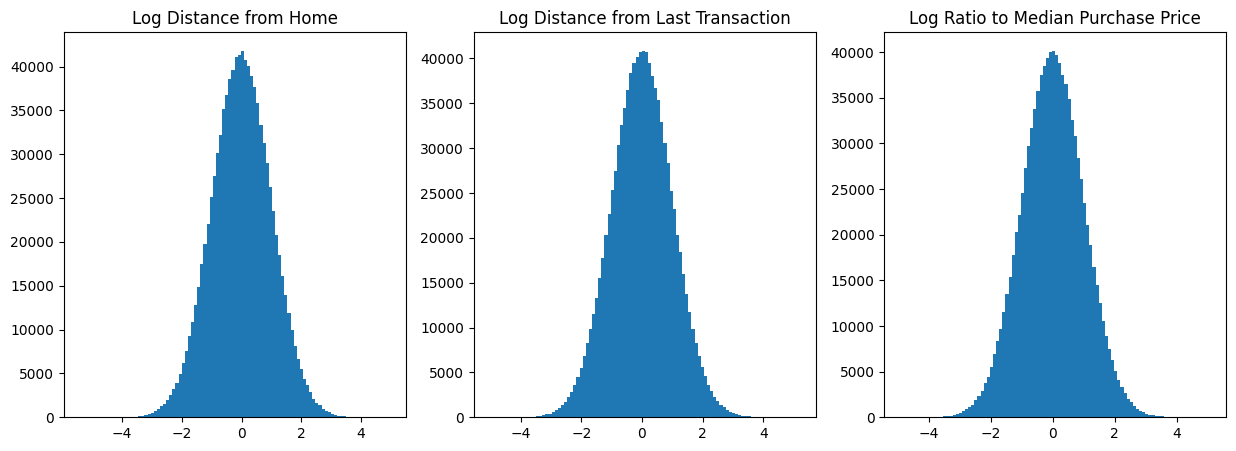

In [14]:
#plot log transformed distributions
#plot them next to each other
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(df['distance_from_home'], bins=100)
axs[0].set_title('Log Distance from Home')

axs[1].hist(df['distance_from_last_transaction'], bins=100)
axs[1].set_title('Log Distance from Last Transaction')

axs[2].hist(df['ratio_to_median_purchase_price'], bins=100)
axs[2].set_title('Log Ratio to Median Purchase Price')

plt.show()


In [15]:
#PC transform data
n_comp = 7
pca = PCA(n_components=n_comp)
pca.fit(df.loc[:, df.columns != 'fraud'])

legit, fraud = pca.transform(legit.loc[:, legit.columns != 'fraud']), pca.transform(fraud.loc[:, fraud.columns != 'fraud'])

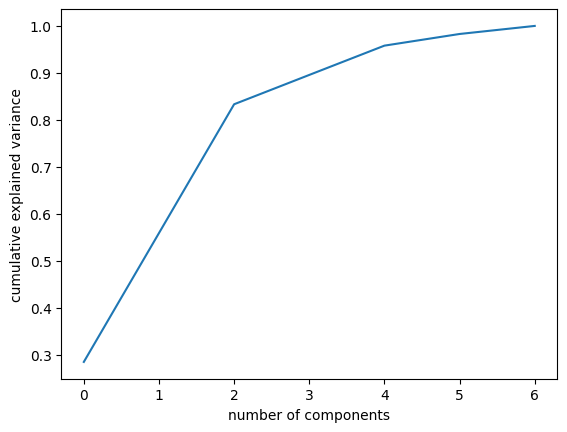

In [16]:
#plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

(250, 7)


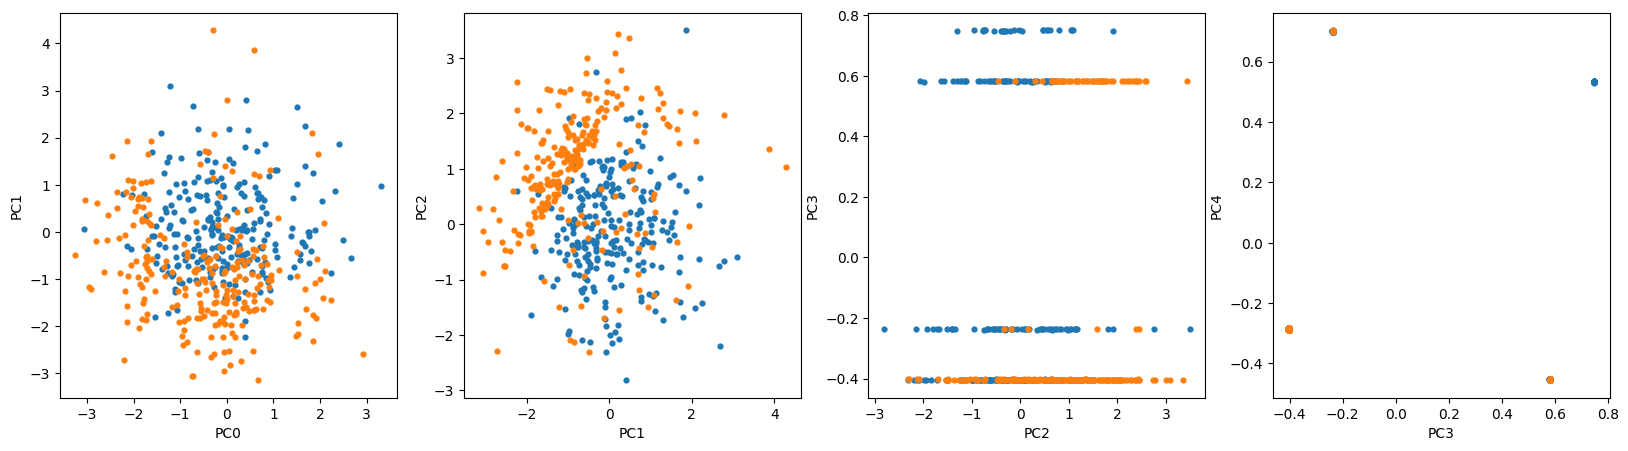

In [17]:
legit_lim = legit[:250]
fraud_lim = fraud[:250]

print(legit_lim.shape)

start = 1
pc = [start+i for i in range(2)]

plots = 4

fig, axs = plt.subplots(1, plots, figsize=(5*plots, 5))

for i in range(plots):
    #reduce scatter size
    axs[i].scatter(legit_lim.T[i], legit_lim.T[i+1], s=12)
    #set labels
    axs[i].set_xlabel(f'PC{i}')
    axs[i].set_ylabel(f'PC{i+1}')
    axs[i].scatter(fraud_lim.T[i], fraud_lim.T[i+1], s=12)

plt.show()

In [158]:

y = df['fraud'].to_numpy()
X = df.drop('fraud', axis='columns').to_numpy()
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,shuffle=True)
SEED = 58 # Set our RNG seed for reproducibility.

#count 1 in y_train
print("1 in y_train: ", np.count_nonzero(y_train == 0))

print(len(y_train))
n_queries = 30 # You can lower this to decrease run time

# You can increase this to get error bars on your evaluation.
# You probably need to use the parallel code to make this reasonable to compute
n_repeats = 5

permutations=[np.random.permutation(X_train.shape[0]) for _ in range(n_repeats)]

for i in range(n_repeats):
    for j in range(5):
        if np.count_nonzero(y_train[permutations[i][j*5:j*5+2]] == 1) == 0:
            index = np.where(y_train == 1)[0][0]
            permutations[i][j*5] = index
            
        if np.count_nonzero(y_train[permutations[i][j*5:j*5+2]] == 0) == 0:
            index = np.where(y_train == 0)[0][0]
            permutations[i][j*5] = index


ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

1 in y_train:  729973
800000


In [187]:
ModelClass=LogisticRegression

def train_committee(i_repeat, n_members, X_train, y_train, n_start):
    committee_results = []
    # print('') # progress bars won't be displayed if not included

    X_pool = X_train.copy()
    y_pool = y_train.copy()

    # print(np.array(permutations).shape)
    qbc_query_indices = permutations[i_repeat][:n_start]
    # us_query_indices=permutations[i_repeat][:n_start]
    
    #check y training if there is 1 and 0
    # for i in range(n_members):
    #     check = qbc_query_indices + i*n_start
        
    #     count = np.count_nonzero(y_train[check] == 1)
        
    #     if count == 0:
    #         qbc_query_indices[0] = np.where(y_train == 1)[0][0] - i*n_start

        
    
    committee_members = [ActiveLearner(estimator=ModelClass(),
                                       X_training=X_train[qbc_query_indices + i*n_start, :],
                                       y_training=y_train[qbc_query_indices + i*n_start],
                                       ) for i in range(n_members)]

    
    committee = Committee(learner_list=committee_members,
                          query_strategy=vote_entropy_sampling)

    X_pool = np.delete(X_pool, qbc_query_indices, axis=0)
    y_pool = np.delete(y_pool, qbc_query_indices)

    for i_query in tqdm(range(1, 2), desc=f'Round {i_repeat} with {n_members} members', leave=False):
        query_idx, query_instance = committee.query(X_pool)

        committee.teach(
            X=X_pool[query_idx].reshape(1, -1),
            y=y_pool[query_idx].reshape(1, )
        )
        committee._set_classes() #this is needed to update for unknown class labels

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)

        # score = committee.score(X_test, y_test)
        score = sklearn.metrics.balanced_accuracy_score(y_test, committee.predict(X_test))

        committee_results.append(ResultsRecord(
            f'committe_{n_members}',
            i_query,
            score))

    return committee_results

In [192]:
com_res = []
for i in range(n_repeats):
    com_res.extend(train_committee(i, 5, X_train, y_train, 20))

# for i in range(n_repeats):
#     res = train_committee(i, 5, X_train, y_train, 5)
#     com_res.append(res)

In [107]:
np.array(uncertain_results).shape

(51, 3)

In [ ]:
#Random Learner
random_results = []

ModelClass=LogisticRegression

n_start = 20

for i_repeat in range(n_repeats):
    start_points = permutations[i_repeat][:n_start]
    selected_points = start_points
    random_learner = ModelClass()
    for i_query in tqdm(range(1,n_queries)):
        query_indices=permutations[i_repeat][:n_start+i_query]
        #random leaner
        random_learner = random_learner.fit(X=X_train[query_indices, :], y=y_train[query_indices])
        # random_score = random_learner.score(X_test, y_test)
        random_score = sklearn.metrics.balanced_accuracy_score(y_test, random_learner.predict(X_test))
        
        random_results.append(ResultsRecord('random', i_query, random_score))
        #committee leaner
    #committee_results = train_committee(i_repeat, 12, X_train, y_train,n_start)



# result = Parallel(n_jobs=-1)(delayed(train_committee)(i,i_members,X_train,y_train, n_start) for i, i_members in it.product(range(n_repeats), n_members))
#Committee Learner




# ModelClass=LogisticRegression
# n_start = 2
# addn = 1

# com_size = 12

# learners = [ActiveLearner(estimator=ModelClass()) for _ in range(com_size)]

# for i_repeat in range(n_repeats):
#     committe = Committee(learner_list=learners,
#                          query_strategy=vote_entropy_sampling)
    
#     for learner in committe:
#         learner.teach(X=X_train[permutations[i_repeat][:n_start], :],
#                       y=y_train[permutations[i_repeat][:n_start]])
        
        



#uncertain learner
uncertain_results = []
ModelClass=LogisticRegression

addn = 1

for i_repeat in range(n_repeats):
    uncertain_learner = ModelClass()
    us_query_indices=permutations[i_repeat][:n_start]
    for i_query in tqdm(range(1,n_queries)):
        
        #random leaner
        uncertain_learner = uncertain_learner.fit(X=X_train[us_query_indices, :], y=y_train[us_query_indices])

        pred = uncertain_learner.predict_proba(X_test)
        uncertain_score = sklearn.metrics.balanced_accuracy_score(y_test, np.argmax(pred, axis=1))
        uncertain_results.append(ResultsRecord('uncertain', i_query, uncertain_score))
        
        pred = uncertain_learner.predict_proba(X_train)
        for _ in range(addn):
            uncertain_index = np.argmax(1-np.max(pred, axis=1))
            pred = np.delete(pred, uncertain_index, axis=0)
            us_query_indices = np.append(us_query_indices, uncertain_index)

print('All jobs done')
# committee_results=[r for rs in result for r in rs]


In [ ]:
# result = Parallel(n_jobs=-1)(delayed(train_committee)(i,i_members,X_train,y_train, n_start) for i, i_members in it.product(range(n_repeats), [2]))

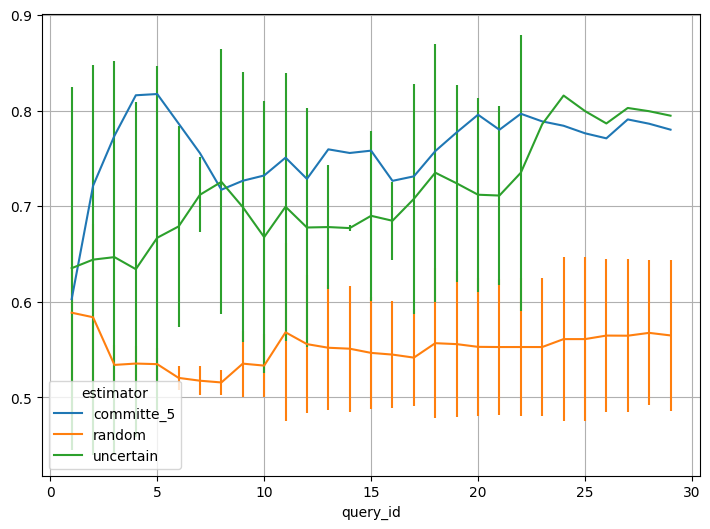

In [126]:
df_results = pd.concat([pd.DataFrame(results)
                        for results in
                        [random_results, uncertain_results, com_res]])

df_results_mean=df_results.groupby(['estimator','query_id']).mean()
df_results_std=df_results.groupby(['estimator','query_id']).std()

df_mean=df_results_mean.reset_index().pivot(index='query_id', columns='estimator', values='score')
df_std=df_results_std.reset_index().pivot(index='query_id', columns='estimator', values='score')

df_mean.plot(figsize=(8.5,6), yerr=df_std)
plt.grid('on')

In [30]:
np.array(uncertain_results).shape

(87, 3)

In [ ]:
uncertain_results = []
ModelClass=LogisticRegression

n_start = 2
addn = 1

for i_repeat in range(n_repeats):
    uncertain_learner = ModelClass()
    us_query_indices=permutations[i_repeat][:n_start]
    for i_query in tqdm(range(1,n_queries)):
        
        #random leaner
        uncertain_learner = uncertain_learner.fit(X=X_train[us_query_indices, :], y=y_train[us_query_indices])

        pred = uncertain_learner.predict_proba(X_test)
        uncertain_score = sklearn.metrics.balanced_accuracy_score(y_test, np.argmax(pred, axis=1))
        uncertain_results.append(ResultsRecord('uncertain', i_query, uncertain_score))
        
        pred = uncertain_learner.predict_proba(X_train)
        for _ in range(addn):
            uncertain_index = np.argmax(1-np.max(pred, axis=1))
            pred = np.delete(pred, uncertain_index, axis=0)
            us_query_indices = np.append(us_query_indices, uncertain_index)

100%|██████████| 99/99 [00:19<00:00,  4.96it/s]
